In [1]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

In [2]:
%matplotlib inline
import pandas as pd
import os,shutil,math,scipy,cv2
import numpy as np
import matplotlib.pyplot as plt
import random as rn

from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,roc_curve,auc

from PIL import Image
from PIL import Image as pil_image
from PIL import ImageDraw

from time import time
from glob import glob
from tqdm import tqdm
from skimage.io import imread
from IPython.display import SVG

from scipy import misc,ndimage
from scipy.ndimage.interpolation import zoom
from scipy.ndimage import imread


from keras import backend as K
from keras.utils.np_utils import to_categorical
from keras import layers
from keras.preprocessing.image import save_img
from keras.utils.vis_utils import model_to_dot
from keras.applications.vgg16 import VGG16,preprocess_input
from keras.models import Input,Model,Sequential
from keras.layers import Dense,Flatten,Dropout,Concatenate,GlobalAveragePooling2D,Lambda,ZeroPadding2D
from keras.layers import SeparableConv2D,BatchNormalization,MaxPooling2D,Conv2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam,SGD
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard,CSVLogger,ReduceLROnPlateau,LearningRateScheduler

Using TensorFlow backend.


In [3]:
# Function to plot loss and accuracy which will get after training the model
def show_final_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('accuracy') # acc to accuracy
    ax[1].plot(history.epoch, history.history["accuracy"], label="Train accuracy") #acc to accuracy
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation accuracy") #acc to accuracy
    ax[0].legend()
    ax[1].legend()

In [4]:
# Functions in order to return the label of a particular image and load the dataset
# Adding images to X array and their labels to Z array
def label_assignment(img,label):
    return label

def training_data(label,data_dir):
    for img in tqdm(os.listdir(data_dir)):
        label = label_assignment(img,label)
        path = os.path.join(data_dir,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img,(imgsize,imgsize))
        
        X.append(np.array(img))
        Z.append(str(label))

In [5]:
## Separate classes for each and every product (determine their paths) 
cereals = 'Dataset/Cereals'
chips = 'Dataset/Chips'
chocolate = 'Dataset/Chocolate'
coffee = 'Dataset/Coffee'
deodorant = 'Dataset/Deodorant'
detergent = 'Dataset/Detergent'
flour = 'Dataset/Flour'
honey = 'Dataset/Honey'
juice = 'Dataset/Juice'
ketchup = 'Dataset/Ketchup'
milk = 'Dataset/Milk'
oil = 'Dataset/Oil'
olive = 'Dataset/Olive'
pasta = 'Dataset/Pasta'
salt = 'Dataset/Salt'
shampoo = 'Dataset/Shampoo'
soap = 'Dataset/Soap'
sugar = 'Dataset/Sugar'
tea = 'Dataset/Tea'
toiletpaper = 'Dataset/ToiletPaper'
tomatosauce = 'Dataset/TomatoSauce'
toothbrush = 'Dataset/Toothbrush'
vinegar = 'Dataset/Vinegar'
water = 'Dataset/Water'
X = []
Z = []
imgsize = 150

In [6]:
## Added my own dataset 
## Called the function to load all the images for every class
training_data('Cereals',cereals)
training_data('Chips',chips)
training_data('Chocolate',chocolate)
training_data('Coffee',coffee)
training_data('Deodorant',deodorant)
training_data('Detergent',detergent)
training_data('Flour',flour)
training_data('Honey',honey)
training_data('Juice',juice)
training_data('Ketchup',ketchup)
training_data('Milk',milk)
training_data('Oil',oil)
training_data('Olive',olive)
training_data('Pasta',pasta)
training_data('Salt',salt)
training_data('Shampoo',shampoo)
training_data('Soap',soap)
training_data('Sugar',sugar)
training_data('Tea',tea)
training_data('ToiletPaper',toiletpaper)
training_data('TomatoSauce',tomatosauce)
training_data('Toothbrush',toothbrush)
training_data('Vinegar',vinegar)
training_data('Water',water)

100%|████████████████████████████████████████| 158/158 [00:49<00:00,  3.18it/s]


In [7]:
## Converted the images to categorical format before finally normalizing the images. 
## Also split the dataset into 2 parts as training set with 80% of data and testing set with 20%.
label_encoder= LabelEncoder()
Y = label_encoder.fit_transform(Z)
Y = to_categorical(Y,24) #24 multi-class for y_train and y_test
X = np.array(X)
X=X/255
## To always get the same output the first time made the split random state = 42(answer of everything)
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,random_state=42)

In [8]:
# Used data augmentation strategies like rotation, zooming and flipping.
augs_gen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False, 
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=10,  
        zoom_range = 0.1, 
        width_shift_range=0.2,  
        height_shift_range=0.2, 
        horizontal_flip=True,  
        vertical_flip=False) 

augs_gen.fit(x_train)

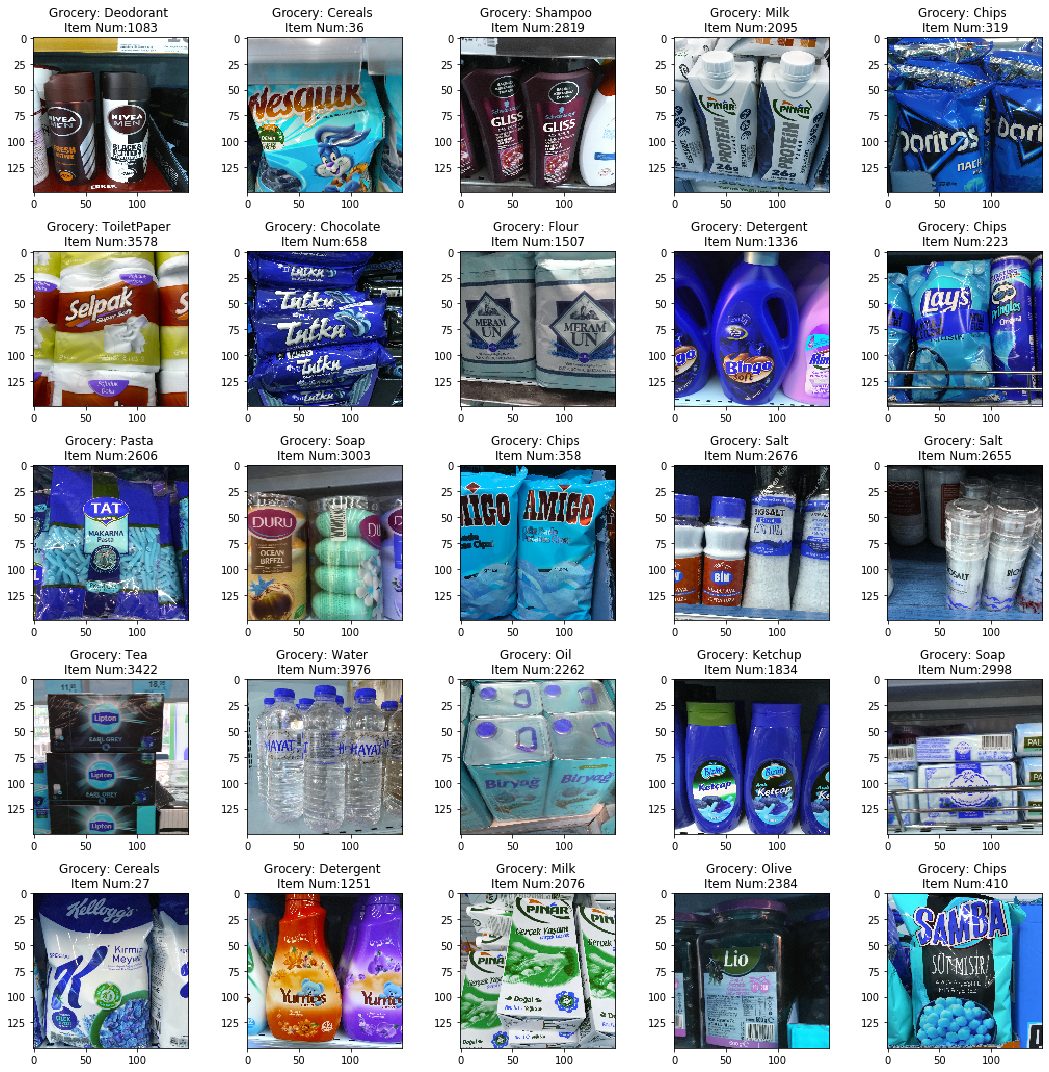

In [9]:
# Display some sample examples from categories.
fig,ax=plt.subplots(5,5)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (5):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Grocery: '+Z[l]+' \nItem Num:'+str(l))
        
plt.tight_layout()

In [10]:
### Used Transfer Learning using pre trained VGG weights
### Used a average pooling layer to reduce the variance 
### of the learned weights from the previous layers
### Used 30% dropouts to reduce over-fitting
### Used a dense layer with 24 neurons for representing 
### the 24 classes of grocery products in dataset
### Used softmax as the actvation function
########################################VGG16 MODEL########################################
#base_model = VGG16(include_top=False,
#                  input_shape = (imgsize,imgsize,3),
#                  weights = 'imagenet')

#for layer in base_model.layers:
#    layer.trainable = False
    
#for layer in base_model.layers:
#    print(layer,layer.trainable)

##model = tensorflow.keras.Sequential()
#model = Sequential()
#model.add(base_model)
#model.add(GlobalAveragePooling2D())
#model.add(Dropout(0.3))
#model.add(Dense(24,activation='softmax')) #24 for output 
##model.add(Dense(5,activation='softmax'))
#model.summary()
### Visualize the model
#SVG(model_to_dot(model).create(prog='dot', format='svg'))
#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 18, 18, 64)        0         
______________________________________

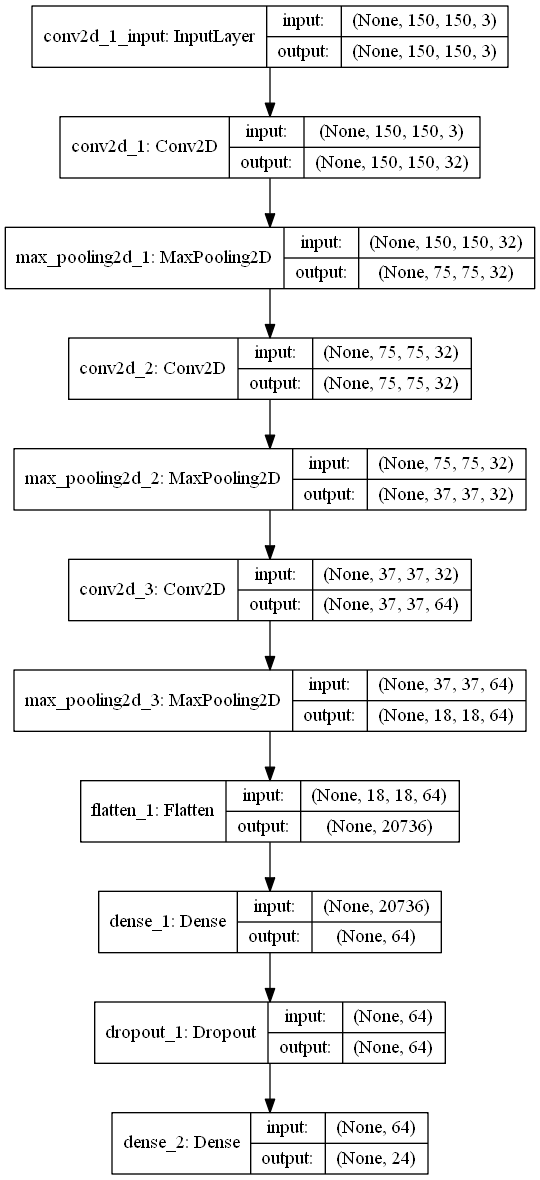

In [11]:
#####################################CNN ONLY MODEL######################################## 
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten , Dropout


model = Sequential()
model.add(Conv2D(32,(3,3),activation='relu',input_shape=(imgsize,imgsize,3),padding='same'))
model.add(MaxPooling2D(pool_size=(2,2))) 
model.add(Conv2D(32,(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2))) 
model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2))) 
model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(24,activation='softmax')) #24 for output 
model.summary()
## Visualize the model
SVG(model_to_dot(model).create(prog='dot', format='svg'))
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [12]:
# Used model checkpoint to save weights if validation accuracy increases
# Used early stopping criterion if validation loss is beginning to plateau
# Saved the logs in csv files
checkpoint = ModelCheckpoint(
    './base.model',
    monitor='val_accuracy', # acc changed as accuracy due to version difference
    verbose=1,
    save_best_only=True,
    mode='max',
    save_weights_only=False,
    period=1
)
earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=30,
    verbose=1,
    mode='auto'
)
tensorboard = TensorBoard(
    log_dir = './logs',
    histogram_freq=0,
    batch_size=16,
    write_graph=True,
    write_grads=True,
    write_images=False,
)

csvlogger = CSVLogger(
    filename= "training_csv.log",
    separator = ",",
    append = False
)

reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1, 
    mode='auto'
)

callbacks = [checkpoint,tensorboard,csvlogger,reduce]

In [13]:
# Defined the 2 optimizers
# First one is stochastic gradient descent with a learning rate of 0.0001 
# and momentum value of 0.99
# Second one is Adam with a learning rate of 0.001

opt = SGD(lr=1e-4,momentum=0.99)
opt1 = Adam(lr=1e-3)

model.compile(
    loss='categorical_crossentropy',
    optimizer=opt1,
    metrics=['accuracy']
)

history = model.fit_generator(
    augs_gen.flow(x_train,y_train,batch_size=128),
    validation_data  = (x_test,y_test),
    validation_steps = 100,
    steps_per_epoch  = 100,
    epochs = 50, 
    verbose = 1,
    callbacks=callbacks
)




Epoch 1/50
100/100 [==============================] - 95s 950ms/step - loss: 2.7651 - accuracy: 0.1592 - val_loss: 2.4995 - val_accuracy: 0.2143

Epoch 00001: val_accuracy improved from -inf to 0.21429, saving model to ./base.model

Epoch 2/50
100/100 [==============================] - 83s 829ms/step - loss: 2.3609 - accuracy: 0.2598 - val_loss: 2.1826 - val_accuracy: 0.3108

Epoch 00002: val_accuracy improved from 0.21429 to 0.31078, saving model to ./base.model
Epoch 3/50
100/100 [==============================] - 85s 851ms/step - loss: 2.0731 - accuracy: 0.3481 - val_loss: 1.8490 - val_accuracy: 0.4298

Epoch 00003: val_accuracy improved from 0.31078 to 0.42982, saving model to ./base.model
Epoch 4/50
100/100 [==============================] - 91s 915ms/step - loss: 1.8371 - accuracy: 0.4298 - val_loss: 1.6554 - val_accuracy: 0.4987

Epoch 00004: val_accuracy improved from 0.42982 to 0.49875, saving model to ./base.model
Epoch 5/50
100/100 [==============================] - 85s 8

100/100 [==============================] - 77s 774ms/step - loss: 0.5306 - accuracy: 0.8217 - val_loss: 0.5541 - val_accuracy: 0.8333

Epoch 00034: val_accuracy did not improve from 0.84837

Epoch 00034: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 35/50
100/100 [==============================] - 79s 789ms/step - loss: 0.5342 - accuracy: 0.8238 - val_loss: 0.5670 - val_accuracy: 0.8383

Epoch 00035: val_accuracy did not improve from 0.84837
Epoch 36/50
100/100 [==============================] - 76s 759ms/step - loss: 0.5319 - accuracy: 0.8244 - val_loss: 0.5695 - val_accuracy: 0.8358

Epoch 00036: val_accuracy did not improve from 0.84837
Epoch 37/50
100/100 [==============================] - 76s 756ms/step - loss: 0.5406 - accuracy: 0.8227 - val_loss: 0.5615 - val_accuracy: 0.8409

Epoch 00037: val_accuracy did not improve from 0.84837

Epoch 00037: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 38/50
100/100 [===================

Weights Saved


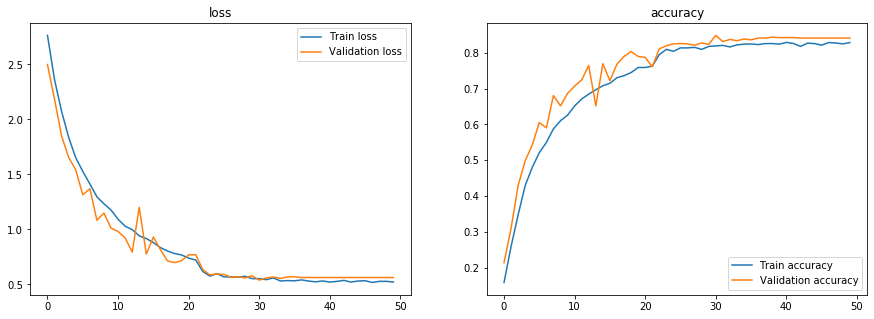

In [14]:
# Plotted the results
show_final_history(history)
model.load_weights('./base.model')

model_json = model.to_json()
with open("model.json","w") as json_file:
    json_file.write(model_json)
    
model.save("model.h5")
print("Weights Saved")

In [15]:
#Shows how much images does my training data has
print(x_train.shape)
print(x_test.shape)
print(y_train.shape[0])

(3189, 150, 150, 3)
(798, 150, 150, 3)
3189


In [16]:
import requests
from PIL import Image

In [17]:
#Test of how we close to 100% / Accuracy test 
model.evaluate(x_test, y_test)


798/798 [==============================] - 1s 2ms/step


[0.5384294111328316, 0.8483709096908569]

[[50  2  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 49  1  1  0  1  0  0  1  0  1  0  0  0  0  0  0  0  2  0  0  0  0  0]
 [ 0  2 46  3  0  0  1  0  1  1  3  0  0  1  0  0  0  0  0  0  0  0  2  0]
 [ 0  2  4 33  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 20  1  0  0  1  0  2  0  0  0  0  2  0  0  1  0  0  0  0  0]
 [ 0  0  0  0  1 67  0  0  0  0  0  0  0  0  0  1  0  0  0  1  0  0  0  0]
 [ 1  0  0  2  0  0 20  0  1  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0]
 [ 0  0  2  1  0  0  0 12  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0]
 [ 2  0  0  1  0  1  0  0 27  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 12  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 2  0  2  1  0  0  0  0  1  0 45  0  0  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 28  0  0  0  0  0  0  2  0  0  0  0  0]
 [ 0  1  1  3  0  0  0  1  0  0  0  0 29  0  0  0  0  0  2  0  0  0  2  0]
 [ 0  1  3  1  0  0  0  0

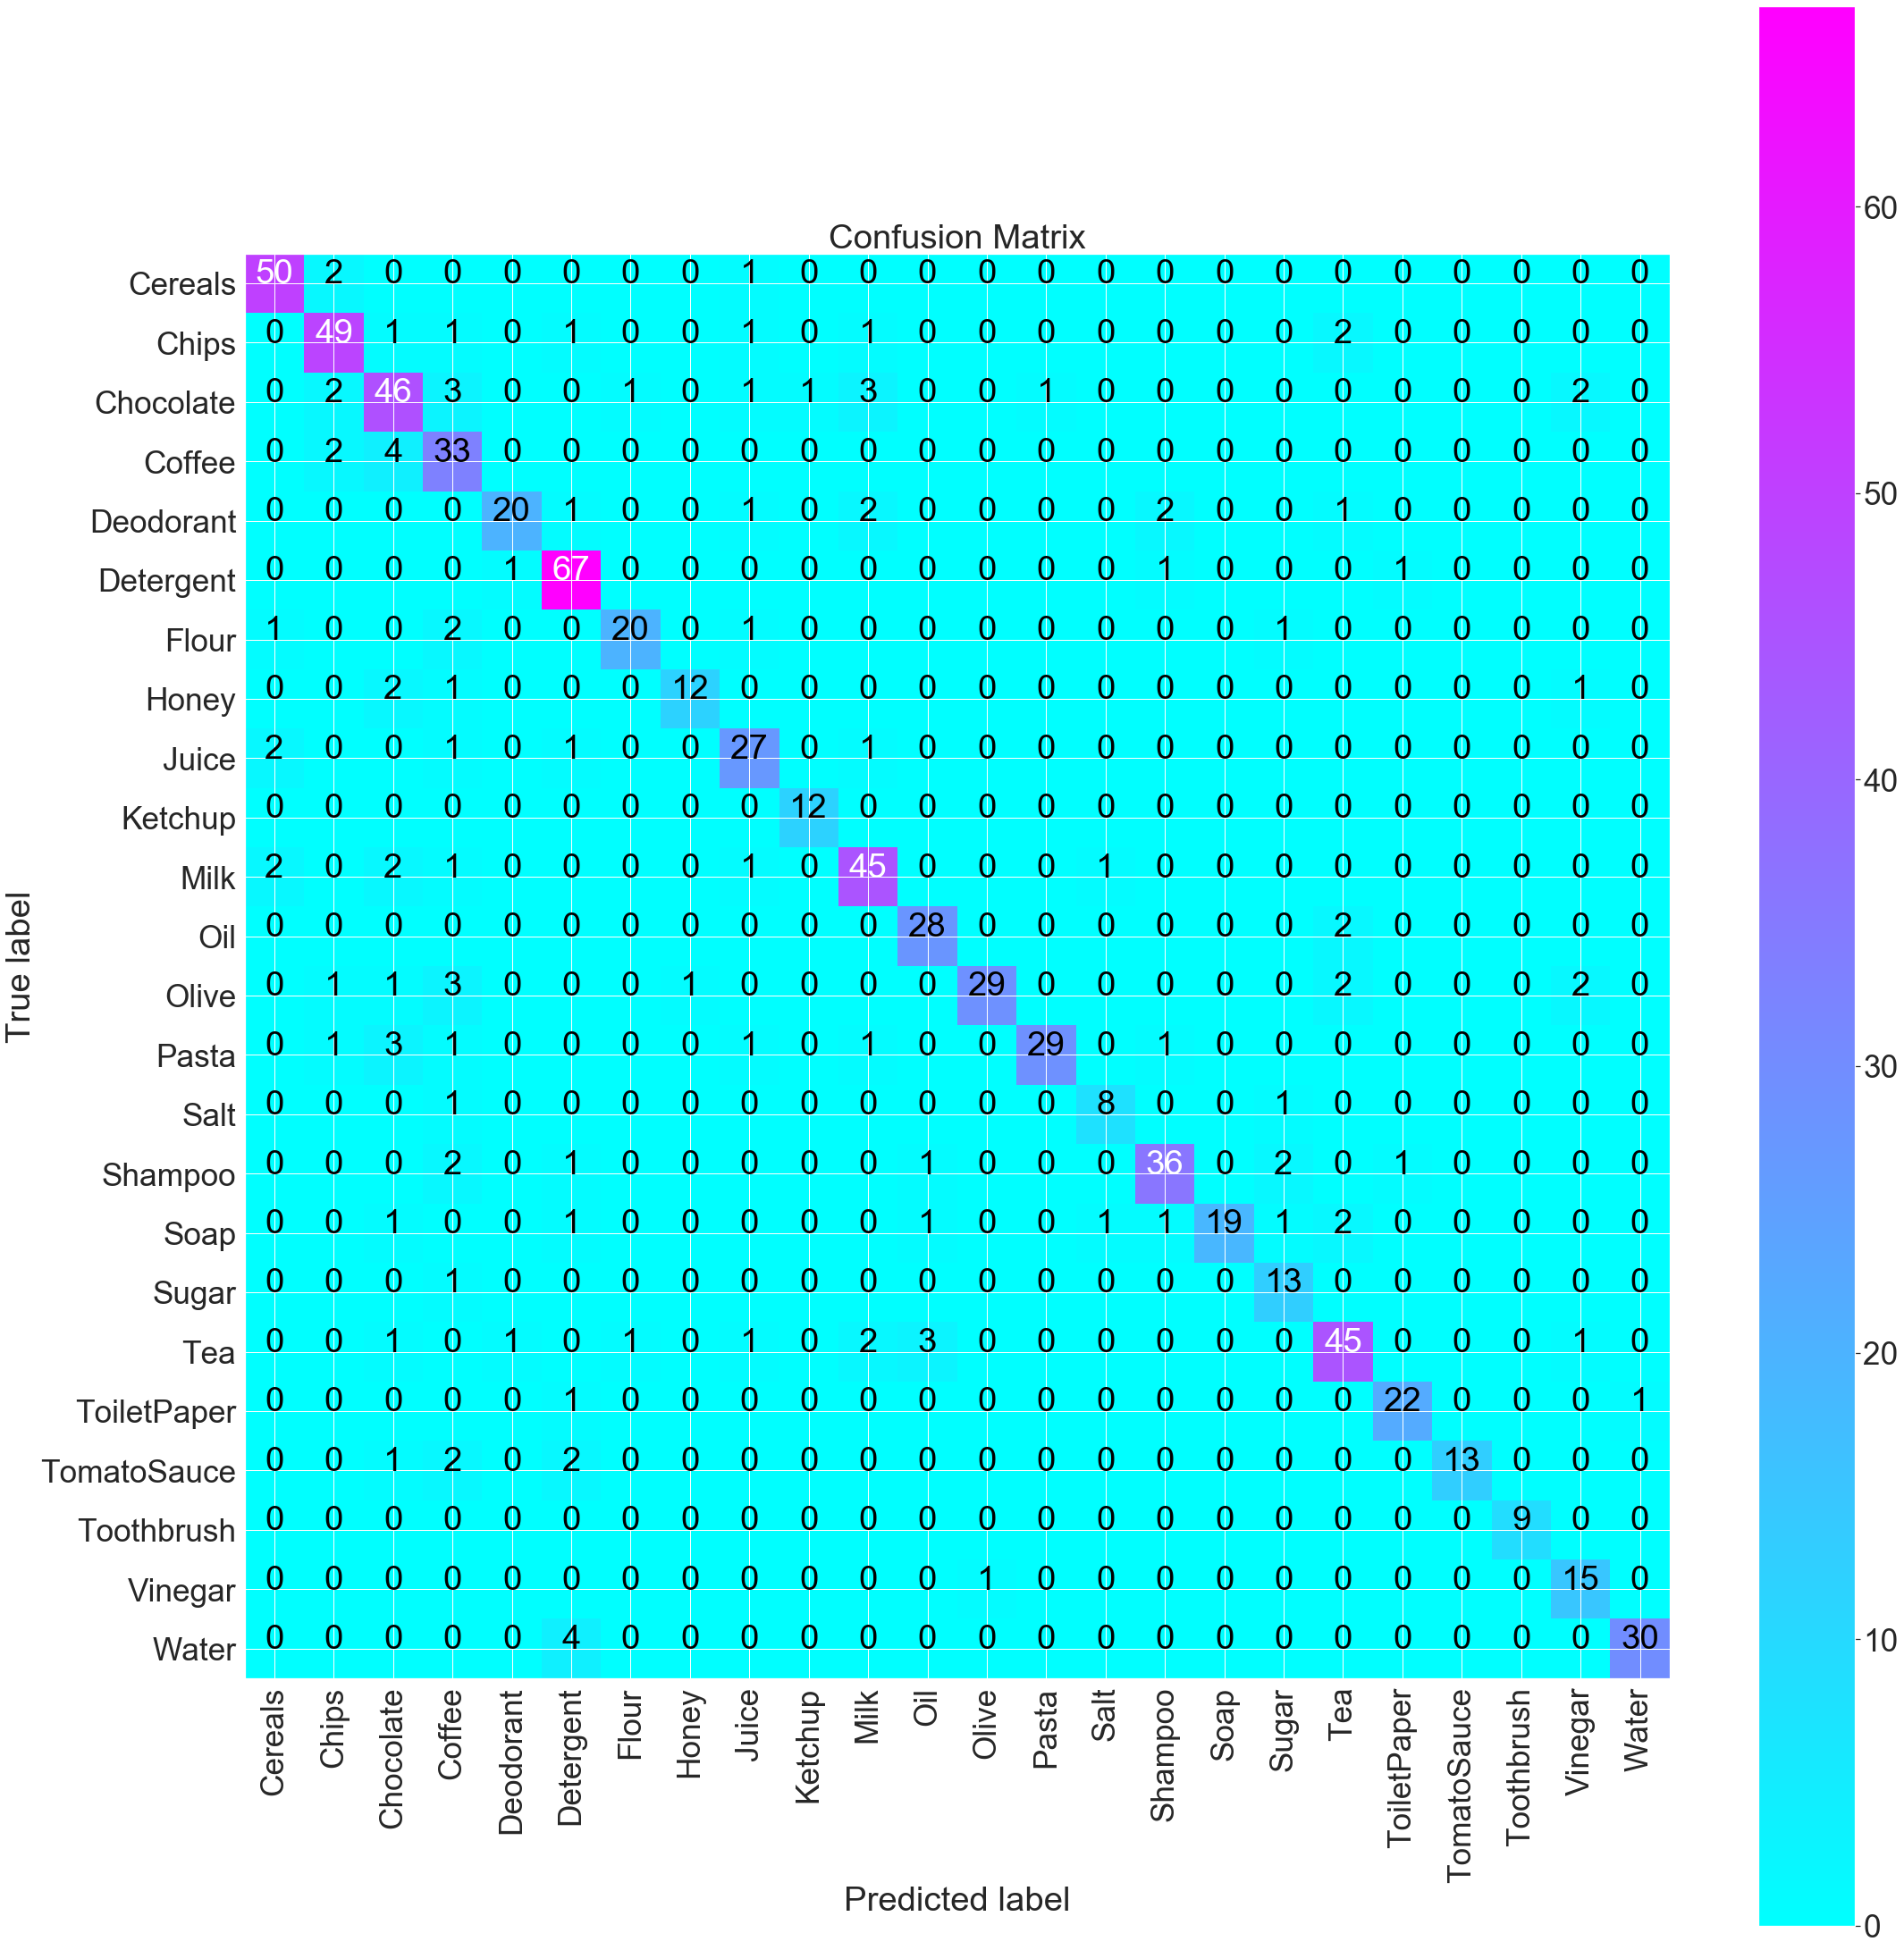

In [18]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.metrics import accuracy_score 
import seaborn as sns
import itertools

rounded_predictions = model.predict_classes(x_test, batch_size=128, verbose=0)
rounded_predictions[1]
rounded_labels=np.argmax(y_test, axis=1)
rounded_labels[1]

cm = confusion_matrix(rounded_labels, rounded_predictions)
print(cm)
print ('Accuracy Score :',accuracy_score(rounded_labels, rounded_predictions)) 
print ("Report : ")
print (classification_report(rounded_labels, rounded_predictions))

FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

print("True Negatives: ",TN)
print("False Positives: ",FP)
print("False Negatives: ",FN)
print("True Positives: ",TP)


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
   
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Confusion Matrix")
    else:
        print('Confusion Matrix')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
sns.set(font_scale=3.2)
ClassNameArray = ["Cereals","Chips","Chocolate","Coffee","Deodorant","Detergent","Flour","Honey","Juice","Ketchup","Milk","Oil","Olive","Pasta","Salt","Shampoo","Soap","Sugar","Tea","ToiletPaper","TomatoSauce","Toothbrush","Vinegar","Water"]
class_names = [ClassNameArray[i] for i in range(24)]

plt.figure()
fig = plt.gcf()
fig.set_size_inches(32, 32)
plot_confusion_matrix(cm, classes=class_names,
                      title='Confusion Matrix',
                      cmap=plt.cm.cool)
plt.show()



In [19]:
#Find the graphic card and tensorflow model - version and their attributes
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
################################################
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")
################################################
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15758460312147065987
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3763404800
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16788689952475862180
physical_device_desc: "device: 0, name: GeForce GTX 860M, pci bus id: 0000:01:00.0, compute capability: 5.0"
]
Default GPU Device: /device:GPU:0
Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 860M, pci bus id: 0000:01:00.0, compute capability: 5.0



In [20]:
data_dir2 = 'C:/Users/onur__000/Desktop/Deneme3/uploads/IMG_2913.JPG'
file = cv2.imread(data_dir2,cv2.IMREAD_COLOR)
file = cv2.resize(file,(imgsize,imgsize))       
img_array = np.asarray(file)
resized = cv2.resize(img_array, (150, 150 ))
resized = np.expand_dims(resized, axis=0)
resized = resized / 255
#
preds = model.predict(resized)
predict = np.argmax(preds,axis=1)
#
prediction = model.predict_classes(resized)
print("Prediction1:")
print(ClassNameArray[int(predict)])
print("\nPrediction2:")
print(ClassNameArray[int(prediction)])

error: OpenCV(4.2.0) C:\projects\opencv-python\opencv\modules\imgproc\src\resize.cpp:4045: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'
